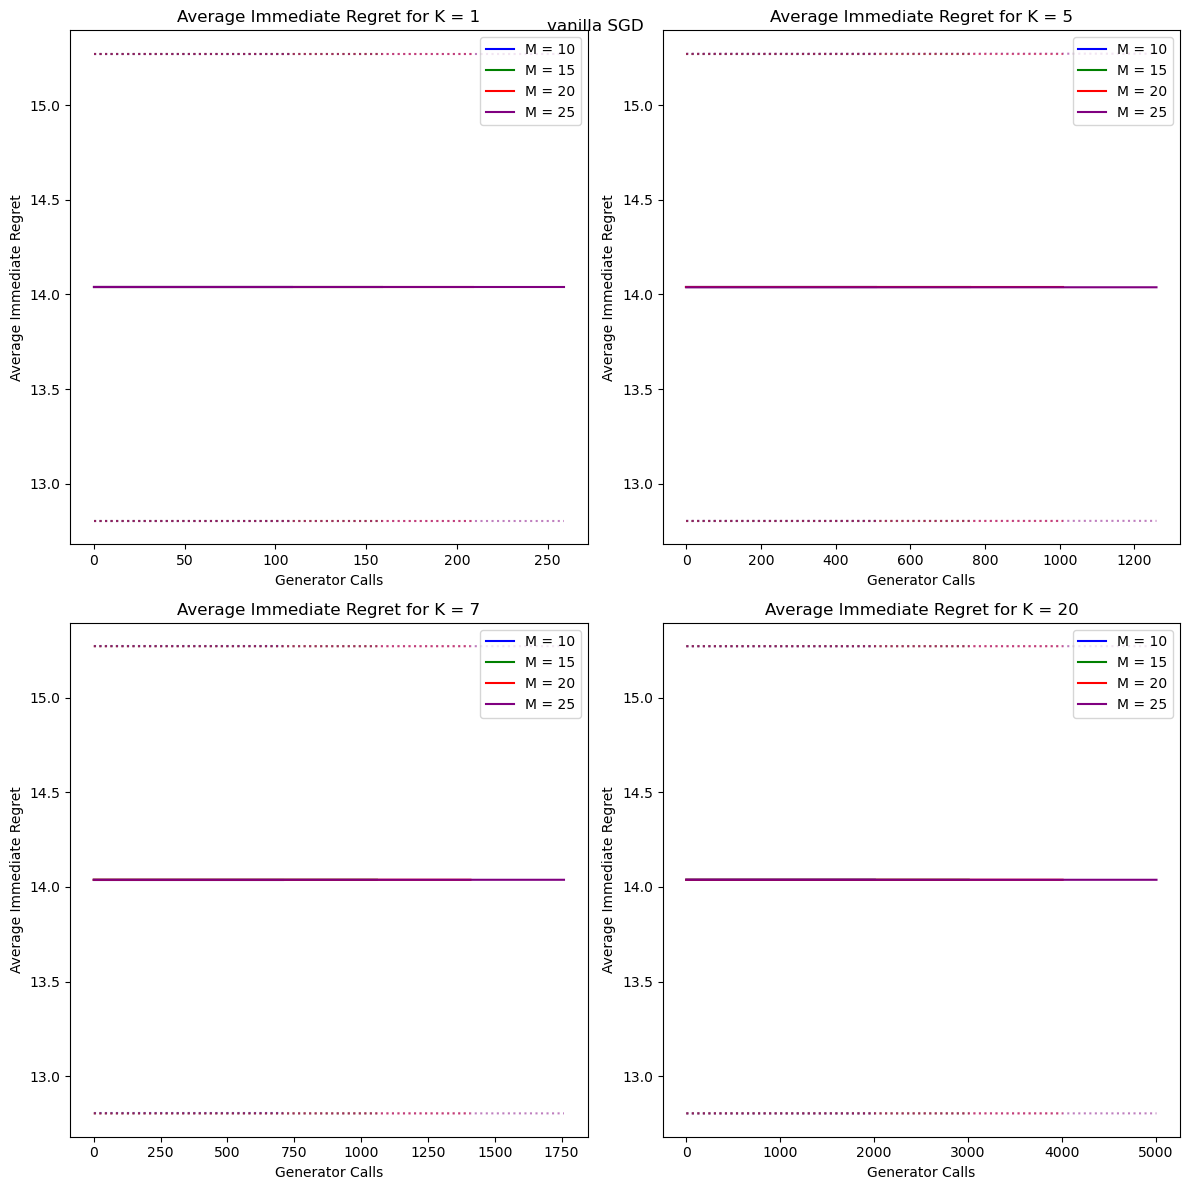

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def ackley_function(x, a=20, b=0.2, c=2*np.pi):
    """计算10维的Ackley函数。
    
    Args:
    x (np.array): 输入数组,维度为10。
    a (float, optional): 参数a,默认为20。
    b (float, optional): 参数b,默认为0.2。
    c (float, optional): 参数c,默认为2π。
    
    Returns:
    float: 函数值。
    """
    d = x.size  # 维度
    sum_sq_term = -a * np.exp(-b * np.sqrt(np.sum(x**2) / d))
    cos_term = -np.exp(np.sum(np.cos(c * x) / d))
    return sum_sq_term + cos_term + a + np.exp(1)


def update_imm_regret(theta, K, M, run):
    global imm_regret, D, global_maximum
    current_value = generator(theta, count=False, K=K, M=M, run=run)  # 获取当前生成器值，不增加计数
    current_imm_regret = global_maximum - current_value  # 计算当前的即时遗憾

    # 如果这是第一个遗憾或者当前遗憾小于最后记录的遗憾，则更新
    if not imm_regret[K][M][run] or current_imm_regret < imm_regret[K][M][run][-1]:
        imm_regret[K][M][run].append(current_imm_regret)
    else:
        # 否则，复制最后一个遗憾值以保持其不变
        imm_regret[K][M][run].append(imm_regret[K][M][run][-1])

def generator(theta, count=True, K=None, M=None, run=None):
    global generator_count, D
    if count:
        generator_count += 1
        generator_counts.append(generator_count)
        if generator_count > 1 and K is not None and M is not None:
            update_imm_regret(D[-1][0], K, M, run)
    return -1 * ackley_function(x=theta)

def noisy_generator(theta, count=True, K=None, M=None, run=None):
    noise = np.random.normal(0, np.sqrt(0.01))
    return generator(theta+noise, count=count, K=K, M=M, run=run)

def neg_grad_log_q(theta, theta_prev, var):
    
    return np.linalg.inv(var) @ (theta - theta_prev)

# Initialize parameters
T = 10
K_values = [1,5,7,20]
eta = 1
var_hyper = np.eye(10)/100
M_values = [10,15,20,25]

global_maximiser = np.zeros(10)
global_maximum = ackley_function(global_maximiser)

num_runs = 100

# Prepare data structure for storing regrets over multiple runs
imm_regret = {k: {m: [[] for _ in range(num_runs)] for m in M_values} for k in K_values}

for run in range(num_runs):
    theta_0 = np.random.uniform(-5, 10, 10)
    for idx, K in enumerate(K_values):
        for M in M_values:
            generator_count = 0
            generator_counts = []  # Store the number of generator calls
            imm_regret[K][M][run] = []  # Initialize the immediate regret list
            D = [(theta_0, noisy_generator(theta_0, K=K, M=M, run=run))]  # Initialize the dataset with the first observation

            for t in range(T):
                max_x = max(x for _, x in D)
                theta_prime = np.copy(D[-1][0])

                for _ in range(K):
                    theta_samples = np.random.multivariate_normal(theta_prime, np.sqrt(var_hyper), M)
                    # print(theta_samples)
                    x_samples = [noisy_generator(theta, K=K, M=M, run=run) for theta in theta_samples]
                    # print(x_samples)
                    z_samples = [1 if x >= max_x else 0 for x in x_samples]
                    # print(z_samples)
                    grads = [neg_grad_log_q(theta, theta_prime, var_hyper) for theta in theta_samples]

                    data_array = np.array([grads[i] for i in range(M) if z_samples[i] == 1])

                    if sum(z_samples) > 0:
                        beta_hat = np.mean(data_array, axis=0) / (sum(z_samples)/len(z_samples))
                    else:
                        beta_hat = np.zeros(10)

                    theta_prime += beta_hat * eta

                x_new = noisy_generator(theta_prime, count=False)
                generator_count +=1
                generator_counts.append(generator_count)
                D.append((theta_prime, x_new))
                update_imm_regret(D[-1][0], K=K, M=M, run=run)

# Calculate and plot average immediate regrets
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

colors = ['blue', 'green', 'red', 'purple']  # 可以根据需要增加更多颜色

for idx, K in enumerate(K_values):
    for m_idx, M in enumerate(M_values):
        all_regrets = np.array(imm_regret[K][M])  # 将遗憾值列表转换为 NumPy 数组以便更容易处理
        avg_regrets = np.mean(all_regrets, axis=0)
        std_regrets = np.std(all_regrets, axis=0)
        generator_counts = np.arange(len(avg_regrets))
        upper_bound = avg_regrets + std_regrets
        lower_bound = avg_regrets - std_regrets

        color = colors[m_idx]  # 为每个 M 值选择一个颜色

    # 绘制实线的平均遗憾
        axs[idx].plot(generator_counts, avg_regrets, label=f'M = {M}', linestyle='solid', color=color)

        axs[idx].plot(generator_counts, upper_bound, linestyle='dotted', alpha=0.5, color=color)

        axs[idx].plot(generator_counts, lower_bound, linestyle='dotted', alpha=0.5, color=color)


    axs[idx].set_title(f'Average Immediate Regret for K = {K}')
    axs[idx].set_xlabel('Generator Calls')
    axs[idx].set_ylabel('Average Immediate Regret')
    # axs[idx].set_yscale('log')
    axs[idx].legend()

plt.tight_layout()
plt.suptitle('vanilla SGD')
plt.show()

## regular ADAM

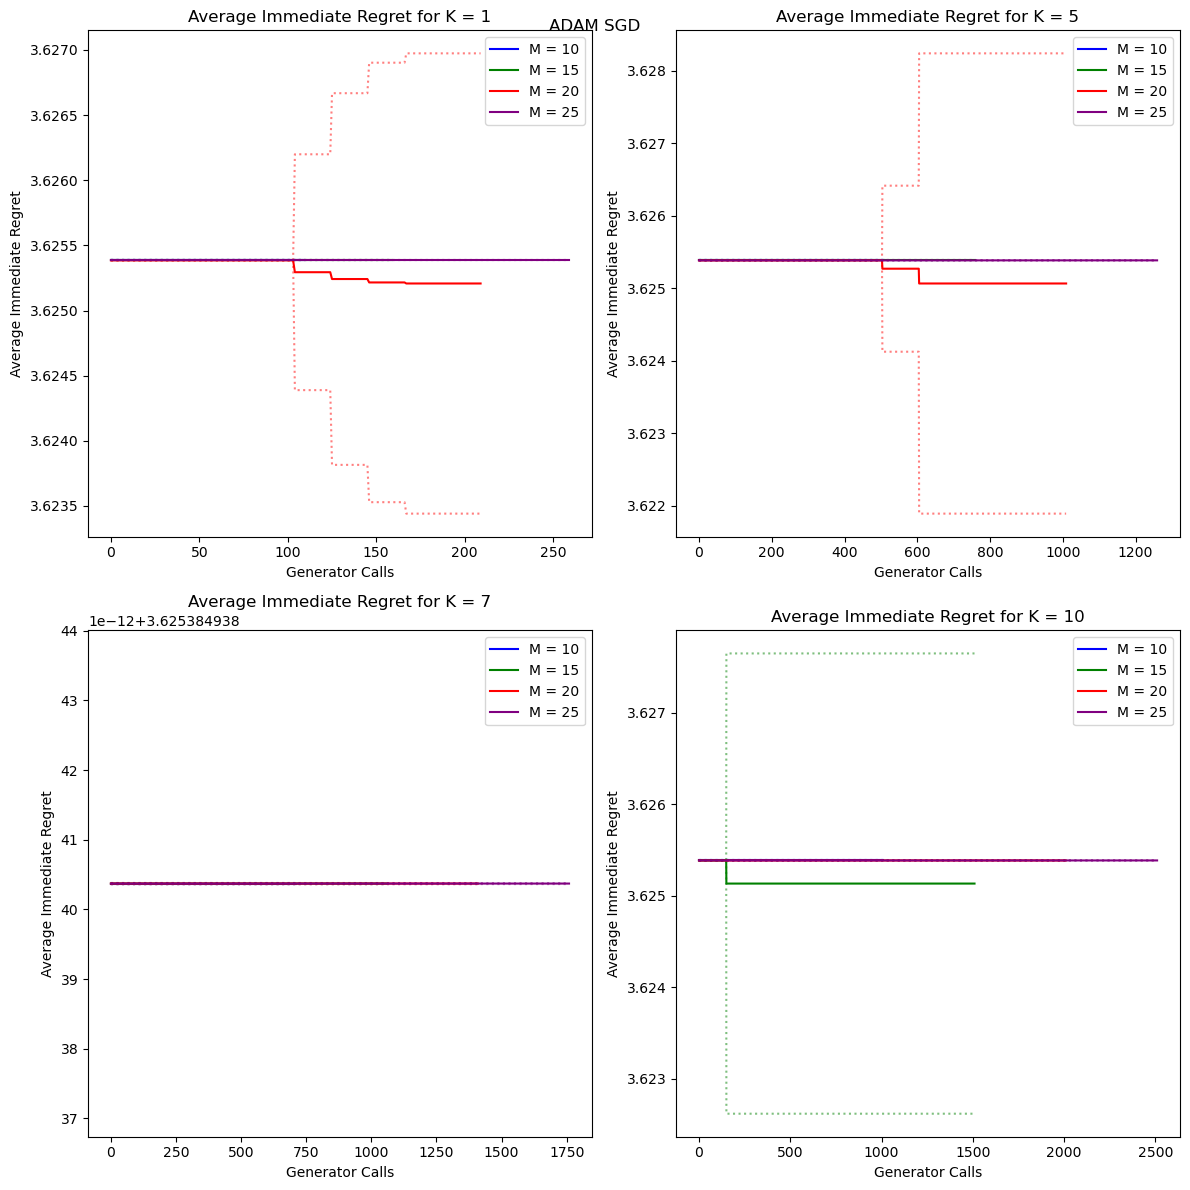

In [5]:
## adam pluggin

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

def ackley_function(x, a=20, b=0.2, c=2*np.pi):
    """计算10维的Ackley函数。
    
    Args:
    x (np.array): 输入数组,维度为10。
    a (float, optional): 参数a,默认为20。
    b (float, optional): 参数b,默认为0.2。
    c (float, optional): 参数c,默认为2π。
    
    Returns:
    float: 函数值。
    """
    d = x.size  # 维度
    sum_sq_term = -a * np.exp(-b * np.sqrt(np.sum(x**2) / d))
    cos_term = -np.exp(np.sum(np.cos(c * x) / d))
    return sum_sq_term + cos_term + a + np.exp(1)

def update_imm_regret(theta, K, M, run):
    global imm_regret, D, global_maximum
    current_value = generator(theta, count=False, K=K, M=M, run=run)  # 获取当前生成器值，不增加计数
    current_imm_regret = global_maximum - current_value  # 计算当前的即时遗憾

    # 如果这是第一个遗憾或者当前遗憾小于最后记录的遗憾，则更新
    if not imm_regret[K][M][run] or current_imm_regret < imm_regret[K][M][run][-1]:
        imm_regret[K][M][run].append(current_imm_regret)
    else:
        # 否则，复制最后一个遗憾值以保持其不变
        imm_regret[K][M][run].append(imm_regret[K][M][run][-1])

def generator(theta, count=True, K=None, M=None, run=None):
    global generator_count, D
    if count:
        generator_count += 1
        generator_counts.append(generator_count)
        if generator_count > 1 and K is not None and M is not None:
            update_imm_regret(D[-1][0], K, M, run)
    return -1 * ackley_function(x=theta)

def noisy_generator(theta, count=True, K=None, M=None, run=None):
    noise = np.random.normal(0, 0.01)
    return generator(theta + noise, count=count, K=K, M=M, run=run) + noise

def neg_grad_log_q(theta, theta_prev, var):
    return np.linalg.inv(var) @ (theta - theta_prev)

def adam_optimizer(grads, m, v, t, beta1=0.9, beta2=0.999, alpha=0.01, epsilon=1e-8):
    t += 1
    m = beta1 * m + (1 - beta1) * grads
    v = beta2 * v + (1 - beta2) * (grads ** 2)

    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)

    theta_update = alpha * m_hat / (np.sqrt(v_hat) + epsilon)
    return theta_update, m, v, t

beta1, beta2 = 0.9, 0.999

# Initialize parameters
T = 10
K_values = [1,5,7,10]
eta = 0.01
var_hyper = np.eye(10)/10
M_values = [10,15,20,25]

global_maximiser = np.zeros(10)
global_maximum = ackley_function(global_maximiser)

num_runs = 100

# Prepare data structure for storing regrets over multiple runs
imm_regret = {k: {m: [[] for _ in range(num_runs)] for m in M_values} for k in K_values}

for run in range(num_runs):
    theta_0 = np.zeros(10) + 1
    for idx, K in enumerate(K_values):
        for M in M_values:
            generator_count = 0
            generator_counts = []  # Store the number of generator calls
            imm_regret[K][M][run] = []  # Initialize the immediate regret list
            D = [(theta_0, generator(theta_0, K=K, M=M, run=run))]  # Initialize the dataset with the first observation

            m, v = np.zeros_like(theta_0), np.zeros_like(theta_0)
            t = 0

            for t in range(T):
                max_x = max(x for _, x in D)
                theta_prime = np.copy(D[-1][0])

                for _ in range(K):
                    theta_samples = np.random.multivariate_normal(theta_prime, var_hyper, M)
                    # print(theta_samples)
                    x_samples = [generator(theta, K=K, M=M, run=run) for theta in theta_samples]
                    # print(x_samples)
                    z_samples = [1 if x >= max_x else 0 for x in x_samples]
                    # print(z_samples)
                    grads = [neg_grad_log_q(theta, theta_prime, var_hyper) for theta in theta_samples]

                    data_array = np.array([grads[i] for i in range(M) if z_samples[i] == 1])

                    if sum(z_samples) > 0:
                        beta_hat = np.mean(data_array, axis=0) / (sum(z_samples)/len(z_samples))
                    else:
                        beta_hat = np.zeros(10)

                    # Adam optimizer update
                    grad_step, m, v, t = adam_optimizer(beta_hat, m, v, t, beta1, beta2, eta)
                    theta_prime += grad_step

                x_new = generator(theta_prime, count=False)
                generator_count +=1
                generator_counts.append(generator_count)
                D.append((theta_prime, x_new))
                update_imm_regret(D[-1][0], K=K, M=M, run=run)


# Calculate and plot average immediate regrets
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

colors = ['blue', 'green', 'red', 'purple']  # 可以根据需要增加更多颜色

for idx, K in enumerate(K_values):
    for m_idx, M in enumerate(M_values):
        all_regrets = np.array(imm_regret[K][M])  # 将遗憾值列表转换为 NumPy 数组以便更容易处理
        avg_regrets = np.mean(all_regrets, axis=0)
        std_regrets = np.std(all_regrets, axis=0)
        generator_counts = np.arange(len(avg_regrets))
        upper_bound = avg_regrets + std_regrets
        lower_bound = avg_regrets - std_regrets

        color = colors[m_idx]  # 为每个 M 值选择一个颜色

    # 绘制实线的平均遗憾
        axs[idx].plot(generator_counts, avg_regrets, label=f'M = {M}', linestyle='solid', color=color)

        axs[idx].plot(generator_counts, upper_bound, linestyle='dotted', alpha=0.5, color=color)

        axs[idx].plot(generator_counts, lower_bound, linestyle='dotted', alpha=0.5, color=color)

    axs[idx].set_title(f'Average Immediate Regret for K = {K}')
    axs[idx].set_xlabel('Generator Calls')
    axs[idx].set_ylabel('Average Immediate Regret')
    # axs[idx].set_yscale('log')
    axs[idx].legend()

plt.tight_layout()
plt.suptitle('ADAM SGD')
plt.show()



## Annealed ADAM

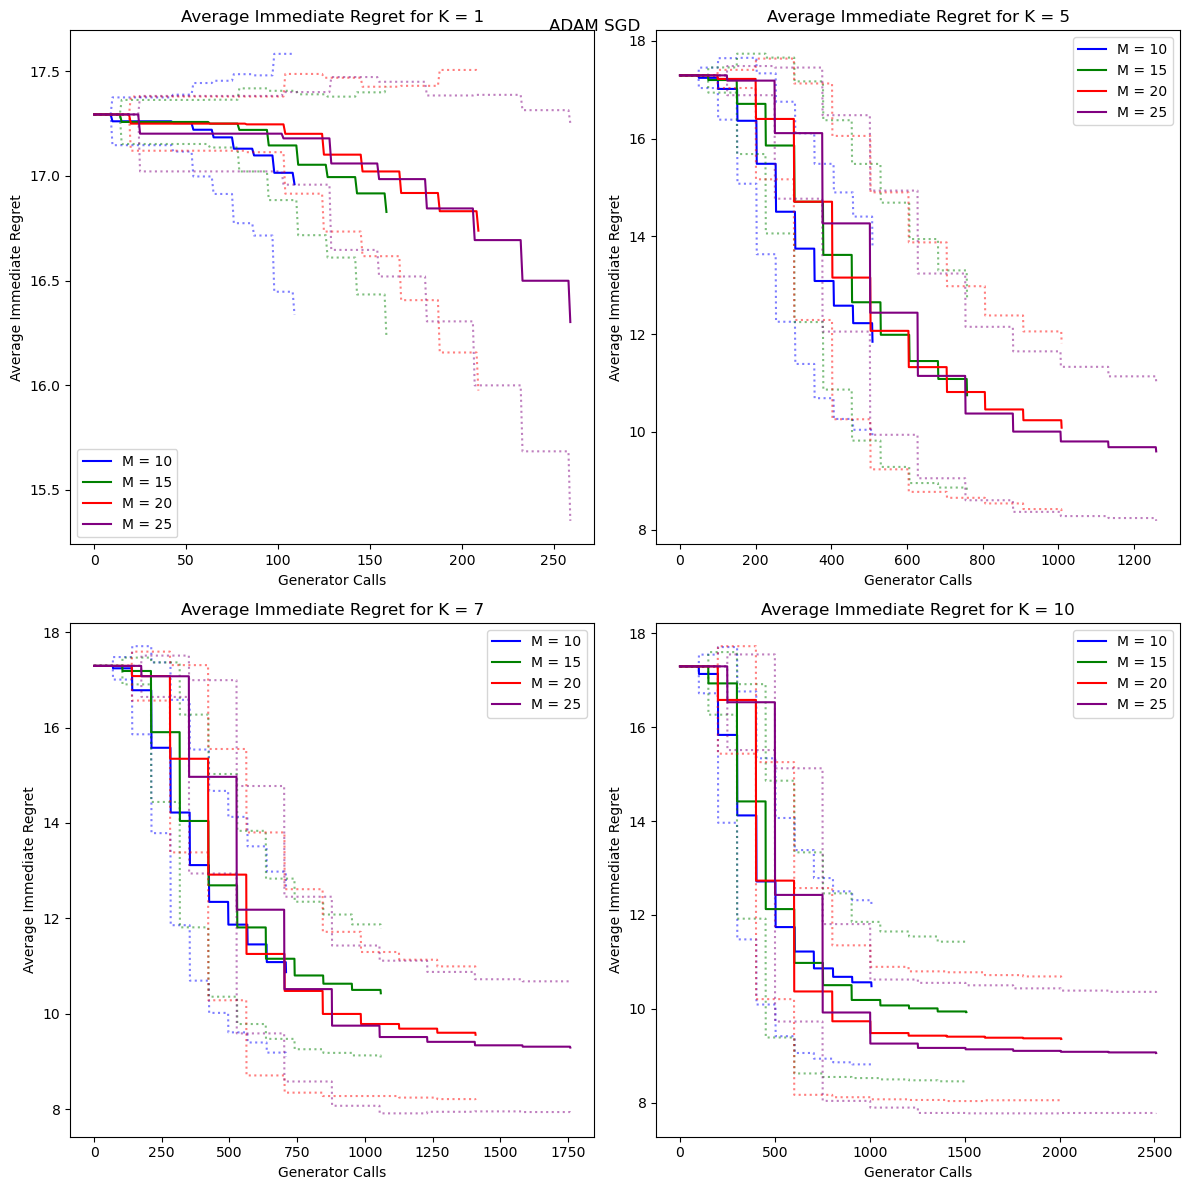

In [6]:
## adam pluggin

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

def ackley_function(x, a=20, b=0.2, c=2*np.pi):
    """计算10维的Ackley函数。
    
    Args:
    x (np.array): 输入数组,维度为10。
    a (float, optional): 参数a,默认为20。
    b (float, optional): 参数b,默认为0.2。
    c (float, optional): 参数c,默认为2π。
    
    Returns:
    float: 函数值。
    """
    d = x.size  # 维度
    sum_sq_term = -a * np.exp(-b * np.sqrt(np.sum(x**2) / d))
    cos_term = -np.exp(np.sum(np.cos(c * x) / d))
    return sum_sq_term + cos_term + a + np.exp(1)

def update_imm_regret(theta, K, M, run):
    global imm_regret, D, global_maximum
    current_value = generator(theta, count=False, K=K, M=M, run=run)  # 获取当前生成器值，不增加计数
    current_imm_regret = global_maximum - current_value  # 计算当前的即时遗憾

    # 如果这是第一个遗憾或者当前遗憾小于最后记录的遗憾，则更新
    if not imm_regret[K][M][run] or current_imm_regret < imm_regret[K][M][run][-1]:
        imm_regret[K][M][run].append(current_imm_regret)
    else:
        # 否则，复制最后一个遗憾值以保持其不变
        imm_regret[K][M][run].append(imm_regret[K][M][run][-1])

def generator(theta, count=True, K=None, M=None, run=None):
    global generator_count, D
    if count:
        generator_count += 1
        generator_counts.append(generator_count)
        if generator_count > 1 and K is not None and M is not None:
            update_imm_regret(D[-1][0], K, M, run)
    return -1 * ackley_function(x=theta)

def noisy_generator(theta, count=True, K=None, M=None, run=None):
    noise = np.random.normal(0, 0.01)
    return generator(theta + noise, count=count, K=K, M=M, run=run) + noise

def neg_grad_log_q(theta, theta_prev, var):
    return np.linalg.inv(var) @ (theta - theta_prev)

def adam_optimizer(grads, m, v, t, beta1=0.9, beta2=0.999, alpha=0.01, epsilon=1e-8):
    t += 1
    m = beta1 * m + (1 - beta1) * grads
    v = beta2 * v + (1 - beta2) * (grads ** 2)

    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)

    theta_update = alpha * m_hat / (np.sqrt(v_hat) + epsilon)
    return theta_update, m, v, t

beta1, beta2 = 0.9, 0.999

# annealing function for the variance of the proposal distribution
def anneal_var_hyper(var_hyper, t, T):
    return var_hyper * (0.9 ** (t / T))

# Initialize parameters
T = 10
K_values = [1,5,7,10]
eta = 1
# var_hyper = np.eye(10)/100
initial_var_hyper = np.eye(10) * 100
M_values = [10,15,20,25]

global_maximiser = np.zeros(10)
global_maximum = ackley_function(global_maximiser)

num_runs = 100

# Prepare data structure for storing regrets over multiple runs
imm_regret = {k: {m: [[] for _ in range(num_runs)] for m in M_values} for k in K_values}

for run in range(num_runs):
    # theta_0 = np.random.uniform(-5, 10, 10)
    theta_0 = np.zeros(10) + 10
    for idx, K in enumerate(K_values):
        for M in M_values:
            generator_count = 0
            generator_counts = []  # Store the number of generator calls
            imm_regret[K][M][run] = []  # Initialize the immediate regret list
            D = [(theta_0, noisy_generator(theta_0, K=K, M=M, run=run))]  # Initialize the dataset with the first observation

            m, v = np.zeros_like(theta_0), np.zeros_like(theta_0)
            t = 0

            for t in range(T):
                max_x = max(x for _, x in D)
                theta_prime = np.copy(D[-1][0])
                
                # 更新 var_hyper
                var_hyper = anneal_var_hyper(initial_var_hyper, t, T)

                for _ in range(K):
                    theta_samples = np.random.multivariate_normal(theta_prime, var_hyper, M)
                    # print(theta_samples)
                    x_samples = [noisy_generator(theta, K=K, M=M, run=run) for theta in theta_samples]
                    # print(x_samples)
                    z_samples = [1 if x >= max_x else 0 for x in x_samples]
                    # print(z_samples)
                    grads = [neg_grad_log_q(theta, theta_prime, var_hyper) for theta in theta_samples]

                    data_array = np.array([grads[i] for i in range(M) if z_samples[i] == 1])

                    if sum(z_samples) > 0:
                        beta_hat = np.mean(data_array, axis=0) / (sum(z_samples)/len(z_samples))
                    else:
                        beta_hat = np.zeros(10)

                    # Adam optimizer update
                    grad_step, m, v, t = adam_optimizer(beta_hat, m, v, t, beta1, beta2, eta)
                    theta_prime += grad_step

                x_new = noisy_generator(theta_prime, count=False)
                generator_count +=1
                generator_counts.append(generator_count)
                D.append((theta_prime, x_new))
                update_imm_regret(D[-1][0], K=K, M=M, run=run)


# Calculate and plot average immediate regrets
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

colors = ['blue', 'green', 'red', 'purple']  # 可以根据需要增加更多颜色

for idx, K in enumerate(K_values):
    for m_idx, M in enumerate(M_values):
        all_regrets = np.array(imm_regret[K][M])  # 将遗憾值列表转换为 NumPy 数组以便更容易处理
        avg_regrets = np.mean(all_regrets, axis=0)
        std_regrets = np.std(all_regrets, axis=0)
        generator_counts = np.arange(len(avg_regrets))
        upper_bound = avg_regrets + std_regrets
        lower_bound = avg_regrets - std_regrets

        color = colors[m_idx]  # 为每个 M 值选择一个颜色

    # 绘制实线的平均遗憾
        axs[idx].plot(generator_counts, avg_regrets, label=f'M = {M}', linestyle='solid', color=color)

        axs[idx].plot(generator_counts, upper_bound, linestyle='dotted', alpha=0.5, color=color)

        axs[idx].plot(generator_counts, lower_bound, linestyle='dotted', alpha=0.5, color=color)

    axs[idx].set_title(f'Average Immediate Regret for K = {K}')
    axs[idx].set_xlabel('Generator Calls')
    axs[idx].set_ylabel('Average Immediate Regret')
    # axs[idx].set_yscale('log')
    axs[idx].legend()

plt.tight_layout()
plt.suptitle('ADAM SGD')
plt.show()



## Adaptive annealing ADAM

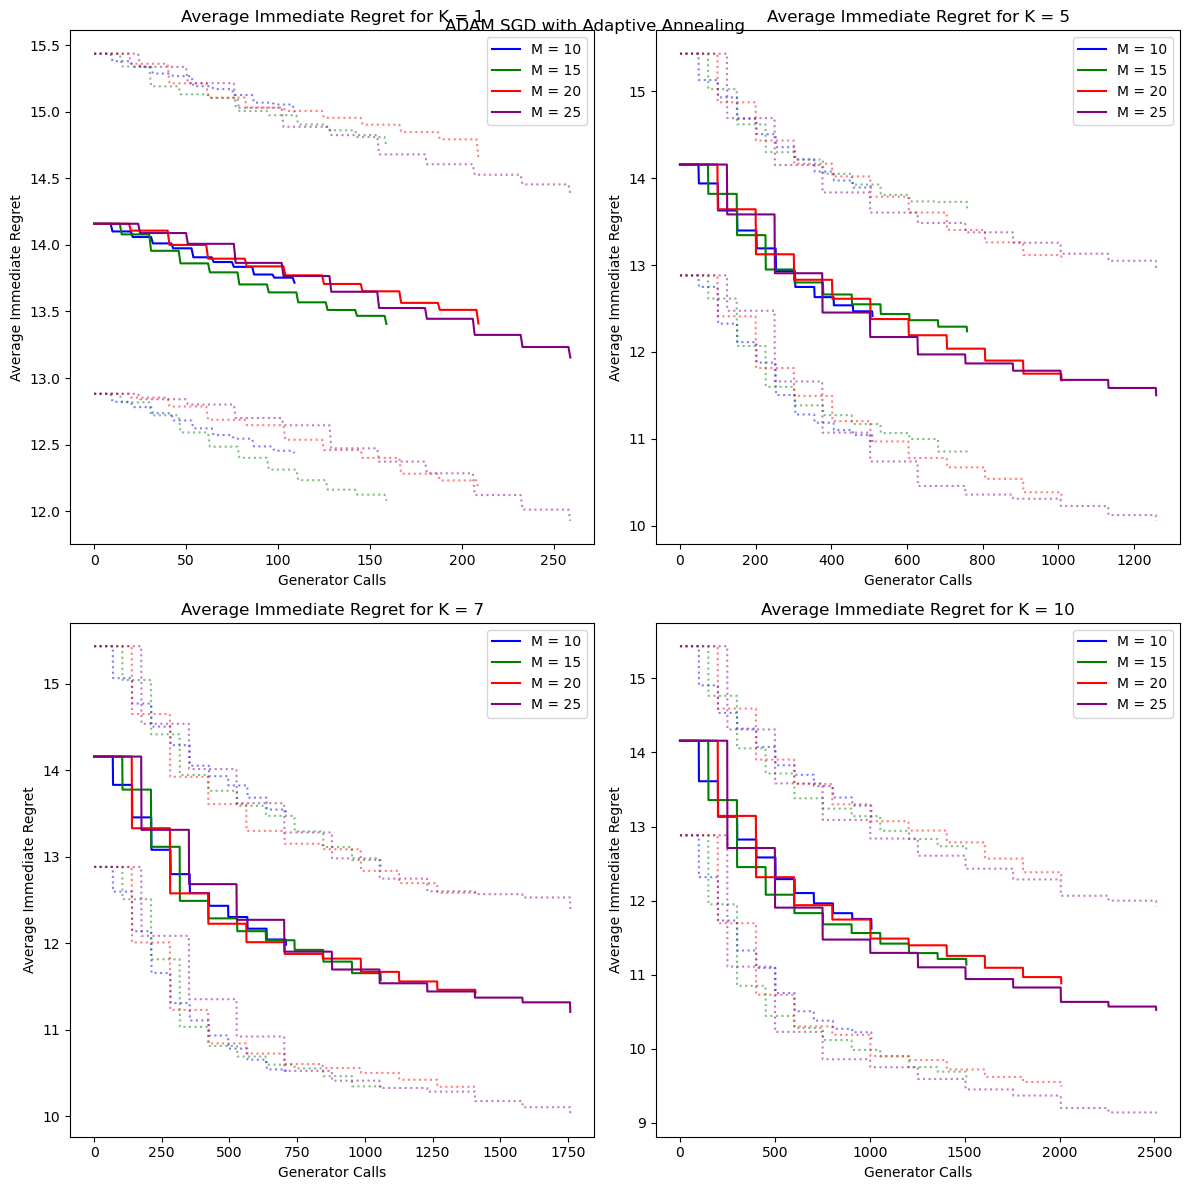

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

def ackley_function(x, a=20, b=0.2, c=2*np.pi):
    d = x.size  # 维度
    sum_sq_term = -a * np.exp(-b * np.sqrt(np.sum(x**2) / d))
    cos_term = -np.exp(np.sum(np.cos(c * x) / d))
    return sum_sq_term + cos_term + a + np.exp(1)

def update_imm_regret(theta, K, M, run):
    global imm_regret, D, global_maximum
    current_value = generator(theta, count=False, K=K, M=M, run=run)
    current_imm_regret = global_maximum - current_value

    if not imm_regret[K][M][run] or current_imm_regret < imm_regret[K][M][run][-1]:
        imm_regret[K][M][run].append(current_imm_regret)
    else:
        imm_regret[K][M][run].append(imm_regret[K][M][run][-1])

def generator(theta, count=True, K=None, M=None, run=None):
    global generator_count, D
    if count:
        generator_count += 1
        generator_counts.append(generator_count)
        if generator_count > 1 and K is not None and M is not None:
            update_imm_regret(D[-1][0], K, M, run)
    return -1 * ackley_function(x=theta)

def noisy_generator(theta, count=True, K=None, M=None, run=None):
    noise = np.random.normal(0, 0.01)
    return generator(theta + noise, count=count, K=K, M=M, run=run) + noise

def neg_grad_log_q(theta, theta_prev, var):
    return np.linalg.inv(var) @ (theta - theta_prev)

def adam_optimizer(grads, m, v, t, beta1=0.9, beta2=0.999, alpha=0.01, epsilon=1e-8):
    t += 1
    m = beta1 * m + (1 - beta1) * grads
    v = beta2 * v + (1 - beta2) * (grads ** 2)

    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)

    theta_update = alpha * m_hat / (np.sqrt(v_hat) + epsilon)
    return theta_update, m, v, t

beta1, beta2 = 0.9, 0.999

def anneal_var_hyper(var_hyper, acceptance_rate, target_rate=0.234, factor=0.1):
    return var_hyper * (1 + factor * (acceptance_rate - target_rate))

# Initialize parameters
T = 10
K_values = [1,5,7,10]
eta = 1
initial_var_hyper = np.eye(10) * 100
M_values = [10,15,20,25]

global_maximiser = np.zeros(10)
global_maximum = ackley_function(global_maximiser)

num_runs = 100

# Prepare data structure for storing regrets over multiple runs
imm_regret = {k: {m: [[] for _ in range(num_runs)] for m in M_values} for k in K_values}

for run in range(num_runs):
    theta_0 = np.random.uniform(-5, 10, 10)
    for idx, K in enumerate(K_values):
        for M in M_values:
            generator_count = 0
            generator_counts = []
            imm_regret[K][M][run] = []
            D = [(theta_0, noisy_generator(theta_0, K=K, M=M, run=run))]

            m, v = np.zeros_like(theta_0), np.zeros_like(theta_0)
            t = 0

            acceptance_count = 0

            for t in range(T):
                max_x = max(x for _, x in D)
                theta_prime = np.copy(D[-1][0])
                
                var_hyper = anneal_var_hyper(initial_var_hyper, acceptance_count / (t+1))

                for _ in range(K):
                    theta_samples = np.random.multivariate_normal(theta_prime, var_hyper, M)
                    x_samples = [noisy_generator(theta, K=K, M=M, run=run) for theta in theta_samples]
                    z_samples = [1 if x >= max_x else 0 for x in x_samples]

                    acceptance_count += sum(z_samples)
                    
                    grads = [neg_grad_log_q(theta, theta_prime, var_hyper) for theta in theta_samples]
                    data_array = np.array([grads[i] for i in range(M) if z_samples[i] == 1])

                    if sum(z_samples) > 0:
                        beta_hat = np.mean(data_array, axis=0) / (sum(z_samples)/len(z_samples))
                    else:
                        beta_hat = np.zeros(10)

                    grad_step, m, v, t = adam_optimizer(beta_hat, m, v, t, beta1, beta2, eta)
                    theta_prime += grad_step

                x_new = noisy_generator(theta_prime, count=False)
                generator_count +=1
                generator_counts.append(generator_count)
                D.append((theta_prime, x_new))
                update_imm_regret(D[-1][0], K=K, M=M, run=run)

# Calculate and plot average immediate regrets
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

colors = ['blue', 'green', 'red', 'purple']

for idx, K in enumerate(K_values):
    for m_idx, M in enumerate(M_values):
        all_regrets = np.array(imm_regret[K][M])
        avg_regrets = np.mean(all_regrets, axis=0)
        std_regrets = np.std(all_regrets, axis=0)
        generator_counts = np.arange(len(avg_regrets))
        upper_bound = avg_regrets + std_regrets
        lower_bound = avg_regrets - std_regrets

        color = colors[m_idx]

        axs[idx].plot(generator_counts, avg_regrets, label=f'M = {M}', linestyle='solid', color=color)
        axs[idx].plot(generator_counts, upper_bound, linestyle='dotted', alpha=0.5, color=color)
        axs[idx].plot(generator_counts, lower_bound, linestyle='dotted', alpha=0.5, color=color)

    axs[idx].set_title(f'Average Immediate Regret for K = {K}')
    axs[idx].set_xlabel('Generator Calls')
    axs[idx].set_ylabel('Average Immediate Regret')
    axs[idx].legend()

plt.tight_layout()
plt.suptitle('ADAM SGD with Adaptive Annealing')
plt.show()


## Fisher

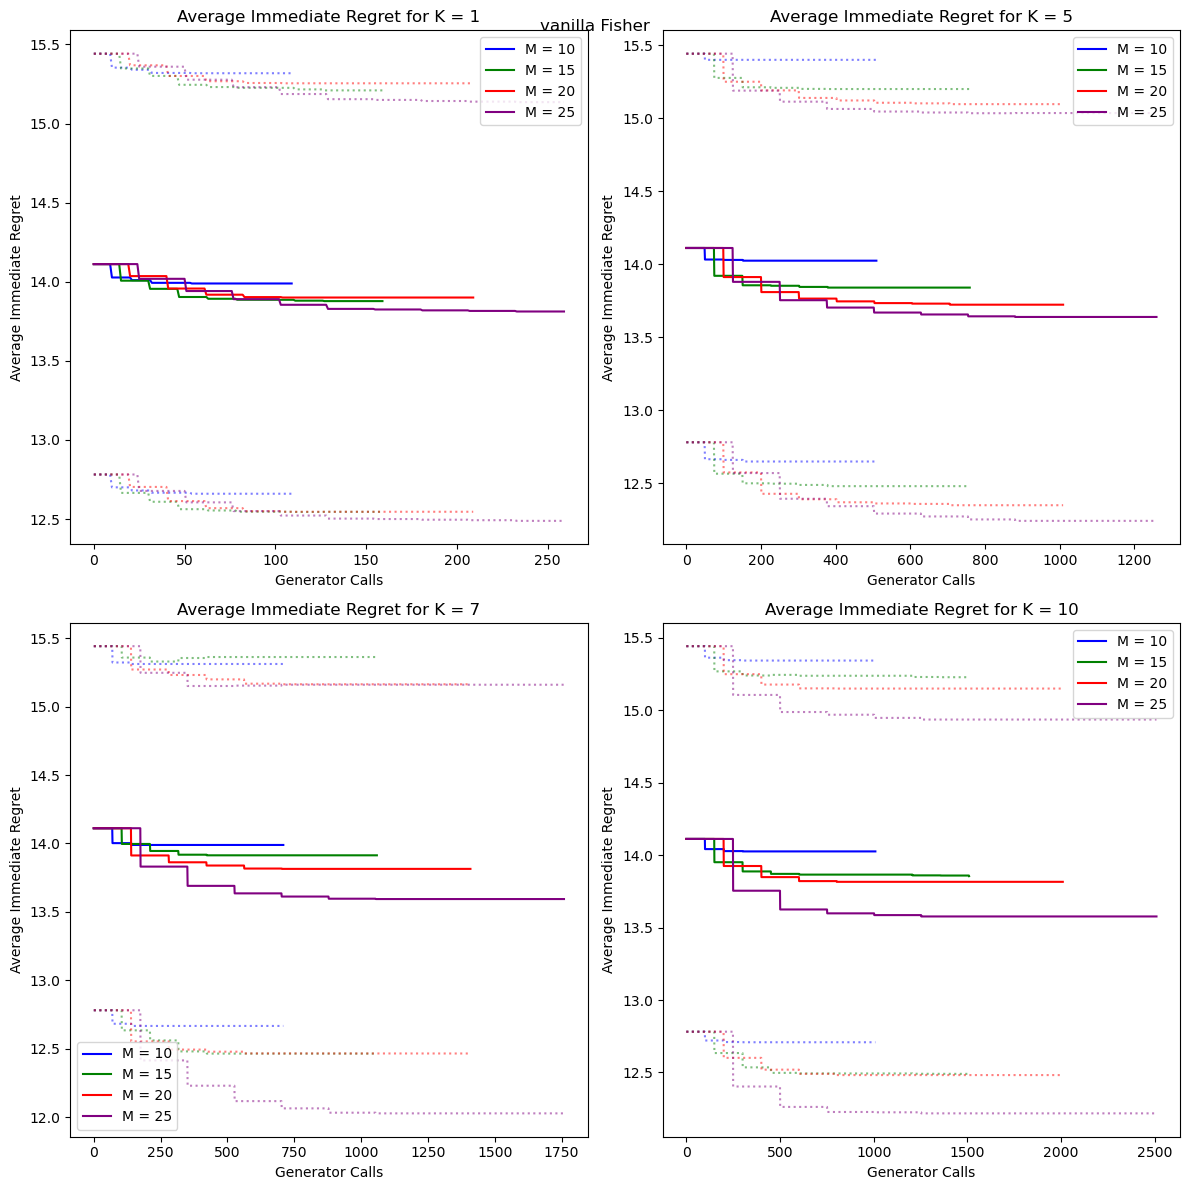

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

def ackley_function(x, a=20, b=0.2, c=2*np.pi):
    """计算10维的Ackley函数。
    
    Args:
    x (np.array): 输入数组,维度为10。
    a (float, optional): 参数a,默认为20。
    b (float, optional): 参数b,默认为0.2。
    c (float, optional): 参数c,默认为2π。
    
    Returns:
    float: 函数值。
    """
    d = x.size  # 维度
    sum_sq_term = -a * np.exp(-b * np.sqrt(np.sum(x**2) / d))
    cos_term = -np.exp(np.sum(np.cos(c * x) / d))
    return sum_sq_term + cos_term + a + np.exp(1)

def update_imm_regret(theta, K, M, run):
    global imm_regret, D, global_maximum
    current_value = generator(theta, count=False, K=K, M=M, run=run)  # 获取当前生成器值，不增加计数
    current_imm_regret = global_maximum - current_value  # 计算当前的即时遗憾

    # 如果这是第一个遗憾或者当前遗憾小于最后记录的遗憾，则更新
    if not imm_regret[K][M][run] or current_imm_regret < imm_regret[K][M][run][-1]:
        imm_regret[K][M][run].append(current_imm_regret)
    else:
        # 否则，复制最后一个遗憾值以保持其不变
        imm_regret[K][M][run].append(imm_regret[K][M][run][-1])

def generator(theta, count=True, K=None, M=None, run=None):
    global generator_count, D
    if count:
        generator_count += 1
        generator_counts.append(generator_count)
        if generator_count > 1 and K is not None and M is not None:
            update_imm_regret(D[-1][0], K, M, run)
    return -1 * ackley_function(x=theta)

def noisy_generator(theta, count=True, K=None, M=None, run=None):
    noise = np.random.normal(0, np.sqrt(0.01))
    return generator(theta, count=count, K=K, M=M, run=run) + noise

def neg_grad_log_q(theta, theta_prev, var):
    return np.linalg.inv(var) @ (theta - theta_prev)

# Initialize parameters
T = 10
K_values = [1,5,7,10]
eta = 1
var_hyper = np.eye(10)/100
M_values = [10,15,20,25]

global_maximiser = np.zeros(10)
global_maximum = ackley_function(global_maximiser)

num_runs = 100

# Prepare data structure for storing regrets over multiple runs
imm_regret = {k: {m: [[] for _ in range(num_runs)] for m in M_values} for k in K_values}

for run in range(num_runs):
    theta_0 = np.random.uniform(-5, 10, 10)
    for idx, K in enumerate(K_values):
        for M in M_values:
            generator_count = 0
            generator_counts = []  # Store the number of generator calls
            imm_regret[K][M][run] = []  # Initialize the immediate regret list
            D = [(theta_0, noisy_generator(theta_0, K=K, M=M, run=run))]  # Initialize the dataset with the first observation

            for t in range(T):
                max_x = max(x for _, x in D)
                theta_prime = np.copy(D[-1][0])

                for _ in range(K):
                    theta_samples = np.random.multivariate_normal(theta_prime, var_hyper, M)
                    # print(theta_samples)
                    x_samples = [noisy_generator(theta, K=K, M=M, run=run) for theta in theta_samples]
                    # print(x_samples)
                    z_samples = [1 if x >= max_x else 0 for x in x_samples]
                    # print(z_samples)
                    grads = [neg_grad_log_q(theta, theta_prime, var_hyper) for theta in theta_samples]

                    data_array = np.array([grads[i] for i in range(M) if z_samples[i] == 1])

                    if sum(z_samples) > 0:
                        beta_hat = np.mean(data_array, axis=0) / (sum(z_samples)/len(z_samples))
                        fisher_info = np.mean([np.outer(grads[i], grads[i]) for i in range(M) if z_samples[i] == 1], axis=0)
                        # fisher_info += np.eye(fisher_info.shape[0]) * 1e-8
                    else:
                        beta_hat = np.zeros(10)
                        fisher_info = np.eye(10) * 1e-8

                    theta_prime += eta * np.linalg.inv(fisher_info) @ beta_hat

                x_new = noisy_generator(theta_prime, count=False)
                generator_count +=1
                generator_counts.append(generator_count)
                D.append((theta_prime, x_new))
                update_imm_regret(D[-1][0], K=K, M=M, run=run)


# Calculate and plot average immediate regrets
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

colors = ['blue', 'green', 'red', 'purple']  # 可以根据需要增加更多颜色

for idx, K in enumerate(K_values):
    for m_idx, M in enumerate(M_values):
        all_regrets = np.array(imm_regret[K][M])  # 将遗憾值列表转换为 NumPy 数组以便更容易处理
        avg_regrets = np.mean(all_regrets, axis=0)
        std_regrets = np.std(all_regrets, axis=0)
        generator_counts = np.arange(len(avg_regrets))
        upper_bound = avg_regrets + std_regrets
        lower_bound = avg_regrets - std_regrets

        color = colors[m_idx]  # 为每个 M 值选择一个颜色

    # 绘制实线的平均遗憾
        axs[idx].plot(generator_counts, avg_regrets, label=f'M = {M}', linestyle='solid', color=color)

        axs[idx].plot(generator_counts, upper_bound, linestyle='dotted', alpha=0.5, color=color)

        axs[idx].plot(generator_counts, lower_bound, linestyle='dotted', alpha=0.5, color=color)

    axs[idx].set_title(f'Average Immediate Regret for K = {K}')
    axs[idx].set_xlabel('Generator Calls')
    axs[idx].set_ylabel('Average Immediate Regret')
    # axs[idx].set_yscale('log')
    axs[idx].legend()

plt.tight_layout()
plt.suptitle('vanilla Fisher')
plt.show()



## Annealed Fisher

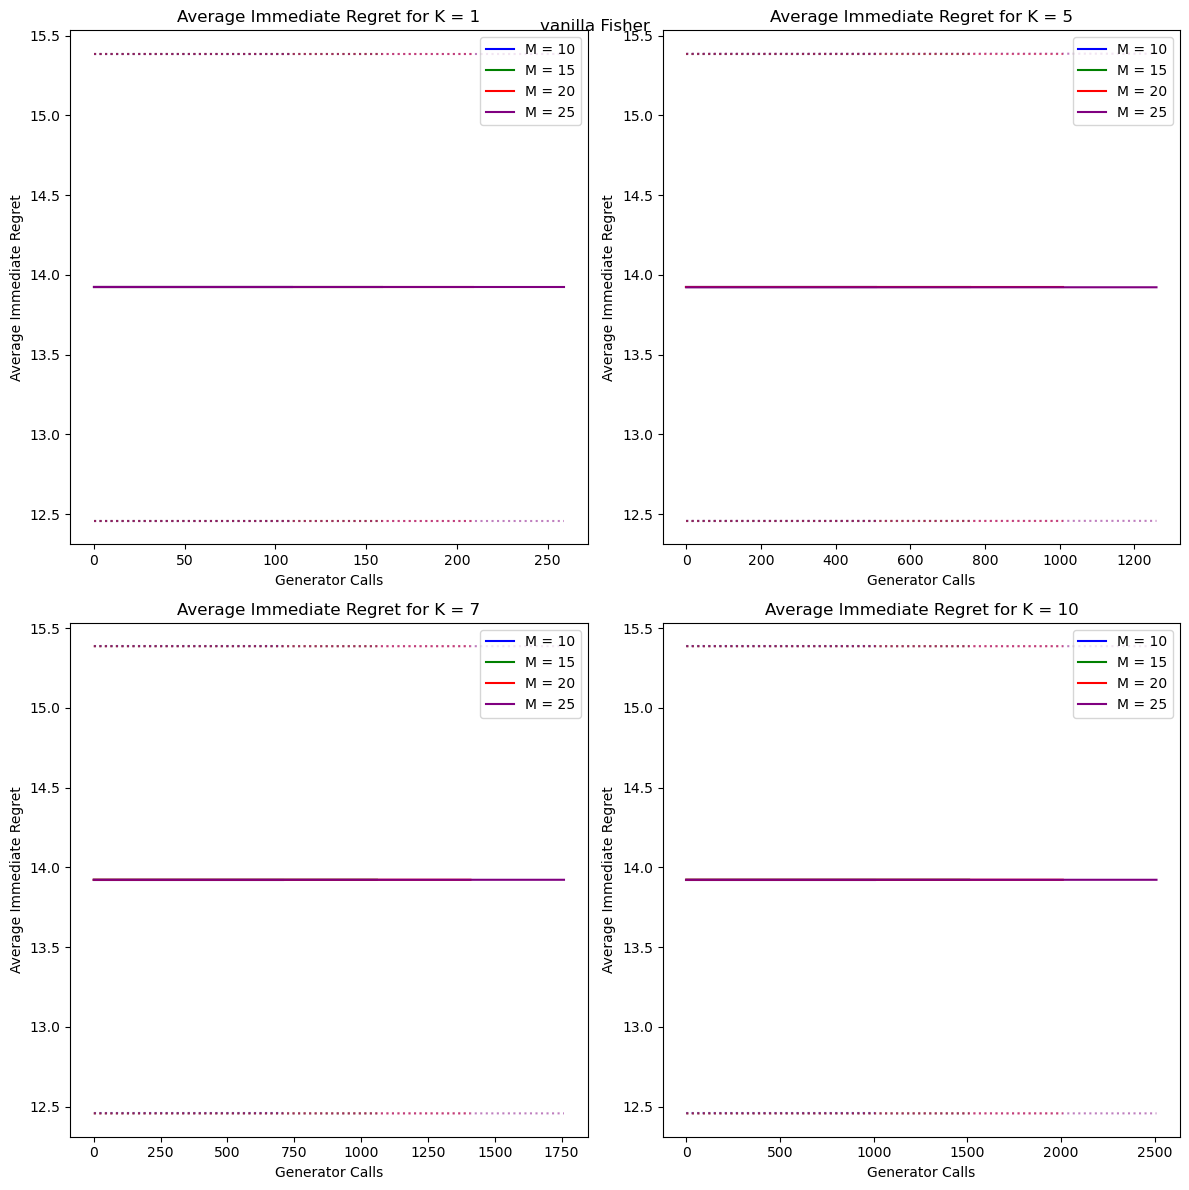

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

def ackley_function(x, a=20, b=0.2, c=2*np.pi):
    """计算10维的Ackley函数。
    
    Args:
    x (np.array): 输入数组,维度为10。
    a (float, optional): 参数a,默认为20。
    b (float, optional): 参数b,默认为0.2。
    c (float, optional): 参数c,默认为2π。
    
    Returns:
    float: 函数值。
    """
    d = x.size  # 维度
    sum_sq_term = -a * np.exp(-b * np.sqrt(np.sum(x**2) / d))
    cos_term = -np.exp(np.sum(np.cos(c * x) / d))
    return sum_sq_term + cos_term + a + np.exp(1)

def update_imm_regret(theta, K, M, run):
    global imm_regret, D, global_maximum
    current_value = generator(theta, count=False, K=K, M=M, run=run)  # 获取当前生成器值，不增加计数
    current_imm_regret = global_maximum - current_value  # 计算当前的即时遗憾

    # 如果这是第一个遗憾或者当前遗憾小于最后记录的遗憾，则更新
    if not imm_regret[K][M][run] or current_imm_regret < imm_regret[K][M][run][-1]:
        imm_regret[K][M][run].append(current_imm_regret)
    else:
        # 否则，复制最后一个遗憾值以保持其不变
        imm_regret[K][M][run].append(imm_regret[K][M][run][-1])

def generator(theta, count=True, K=None, M=None, run=None):
    global generator_count, D
    if count:
        generator_count += 1
        generator_counts.append(generator_count)
        if generator_count > 1 and K is not None and M is not None:
            update_imm_regret(D[-1][0], K, M, run)
    return -1 * ackley_function(x=theta)

def noisy_generator(theta, count=True, K=None, M=None, run=None):
    noise = np.random.normal(0, np.sqrt(0.01))
    return generator(theta, count=count, K=K, M=M, run=run) + noise

def neg_grad_log_q(theta, theta_prev, var):
    return np.linalg.inv(var) @ (theta - theta_prev)

# annealing function for the variance of the proposal distribution
def anneal_var_hyper(var_hyper, t, T):
    return var_hyper * (0.9 ** (t / T))


# Initialize parameters
T = 10
K_values = [1,5,7,10]
eta = 1
# var_hyper = np.eye(10)/100
initial_var_hyper = np.eye(10) * 100
M_values = [10,15,20,25]

global_maximiser = np.zeros(10)
global_maximum = ackley_function(global_maximiser)

num_runs = 100

# Prepare data structure for storing regrets over multiple runs
imm_regret = {k: {m: [[] for _ in range(num_runs)] for m in M_values} for k in K_values}

for run in range(num_runs):
    theta_0 = np.random.uniform(-5, 10, 10)
    for idx, K in enumerate(K_values):
        for M in M_values:
            generator_count = 0
            generator_counts = []  # Store the number of generator calls
            imm_regret[K][M][run] = []  # Initialize the immediate regret list
            D = [(theta_0, noisy_generator(theta_0, K=K, M=M, run=run))]  # Initialize the dataset with the first observation

            for t in range(T):
                max_x = max(x for _, x in D)
                theta_prime = np.copy(D[-1][0])

                # 更新 var_hyper
                var_hyper = anneal_var_hyper(initial_var_hyper, t, T)

                for _ in range(K):
                    theta_samples = np.random.multivariate_normal(theta_prime, var_hyper, M)
                    # print(theta_samples)
                    x_samples = [noisy_generator(theta, K=K, M=M, run=run) for theta in theta_samples]
                    # print(x_samples)
                    z_samples = [1 if x >= max_x else 0 for x in x_samples]
                    # print(z_samples)
                    grads = [neg_grad_log_q(theta, theta_prime, var_hyper) for theta in theta_samples]

                    data_array = np.array([grads[i] for i in range(M) if z_samples[i] == 1])

                    if sum(z_samples) > 0:
                        beta_hat = np.mean(data_array, axis=0) / (sum(z_samples)/len(z_samples))
                        fisher_info = np.mean([np.outer(grads[i], grads[i]) for i in range(M) if z_samples[i] == 1], axis=0)
                        # fisher_info += np.eye(fisher_info.shape[0]) * 1e-8
                    else:
                        beta_hat = np.zeros(10)
                        fisher_info = np.eye(10) * 1e-8

                    theta_prime += eta * np.linalg.inv(fisher_info) @ beta_hat

                x_new = noisy_generator(theta_prime, count=False)
                generator_count +=1
                generator_counts.append(generator_count)
                D.append((theta_prime, x_new))
                update_imm_regret(D[-1][0], K=K, M=M, run=run)


# Calculate and plot average immediate regrets
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

colors = ['blue', 'green', 'red', 'purple']  # 可以根据需要增加更多颜色

for idx, K in enumerate(K_values):
    for m_idx, M in enumerate(M_values):
        all_regrets = np.array(imm_regret[K][M])  # 将遗憾值列表转换为 NumPy 数组以便更容易处理
        avg_regrets = np.mean(all_regrets, axis=0)
        std_regrets = np.std(all_regrets, axis=0)
        generator_counts = np.arange(len(avg_regrets))
        upper_bound = avg_regrets + std_regrets
        lower_bound = avg_regrets - std_regrets

        color = colors[m_idx]  # 为每个 M 值选择一个颜色

    # 绘制实线的平均遗憾
        axs[idx].plot(generator_counts, avg_regrets, label=f'M = {M}', linestyle='solid', color=color)

        axs[idx].plot(generator_counts, upper_bound, linestyle='dotted', alpha=0.5, color=color)

        axs[idx].plot(generator_counts, lower_bound, linestyle='dotted', alpha=0.5, color=color)

    axs[idx].set_title(f'Average Immediate Regret for K = {K}')
    axs[idx].set_xlabel('Generator Calls')
    axs[idx].set_ylabel('Average Immediate Regret')
    # axs[idx].set_yscale('log')
    axs[idx].legend()

plt.tight_layout()
plt.suptitle('vanilla Fisher')
plt.show()

